# Partie A

## MODEL 2 - LSTM

### Group members :
    -CHAMINADE Yann : 72829
    -DEQUIDT Simon : 94234
    -KULAGA Sacha : 79015
    -RIBEIRO Antoine : 74675

In [4]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

#LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [5]:
data = pd.read_csv("data_training_Project_ML_Finance.csv")
data

Day    Weekday Macro Environment    ABC     MKV    YYT    PLO    ERS  \
0      1     Monday          Positive  100.00  56.00  70.00  25.00  64.96   
1      2    Tuesday          Positive  100.39  55.94  70.80  24.81  64.99   
2      3  Wednesday          Positive   99.99  55.74  70.01  24.97  64.66   
3      4    Thurday          Positive   99.73  55.36  71.03  25.09  64.81   
4      5     Friday          Positive  100.27  55.39  71.12  24.93  65.02   
..   ...        ...               ...     ...    ...    ...    ...    ...   
745  746     Monday           Neutral  117.16  65.65  29.65  24.30  66.33   
746  747    Tuesday           Neutral  117.06  65.65  29.34  24.16  66.43   
747  748  Wednesday           Neutral  116.87  65.02  28.89  24.33  66.27   
748  749    Thurday           Neutral  116.94  64.49  29.25  24.54  66.28   
749  750     Friday           Neutral  114.80  65.02  29.44  24.51  66.46   

       HUY   MON     AQE     IX50  
0    76.12  32.02  23.01  1200.00  
1    75.98  32.00  23.03  1201.14  
2    76.29  32.03  23.02  1209.88  
3    76.01  32.04  23.02  1195.59  
4    75.83  32.01  23.00  1185.64  
..     ...    ...    ...      ...  
745  73.53  31.71  22.68  1822.46  
746  73.50  31.71  22.69  1833.02  
747  73.67  31.74  22.69  1829.48  
748  73.64  31.75  22.70  1827.91  
749  73.70  31.72  22.66  1825.61  

[750 rows x 12 columns]

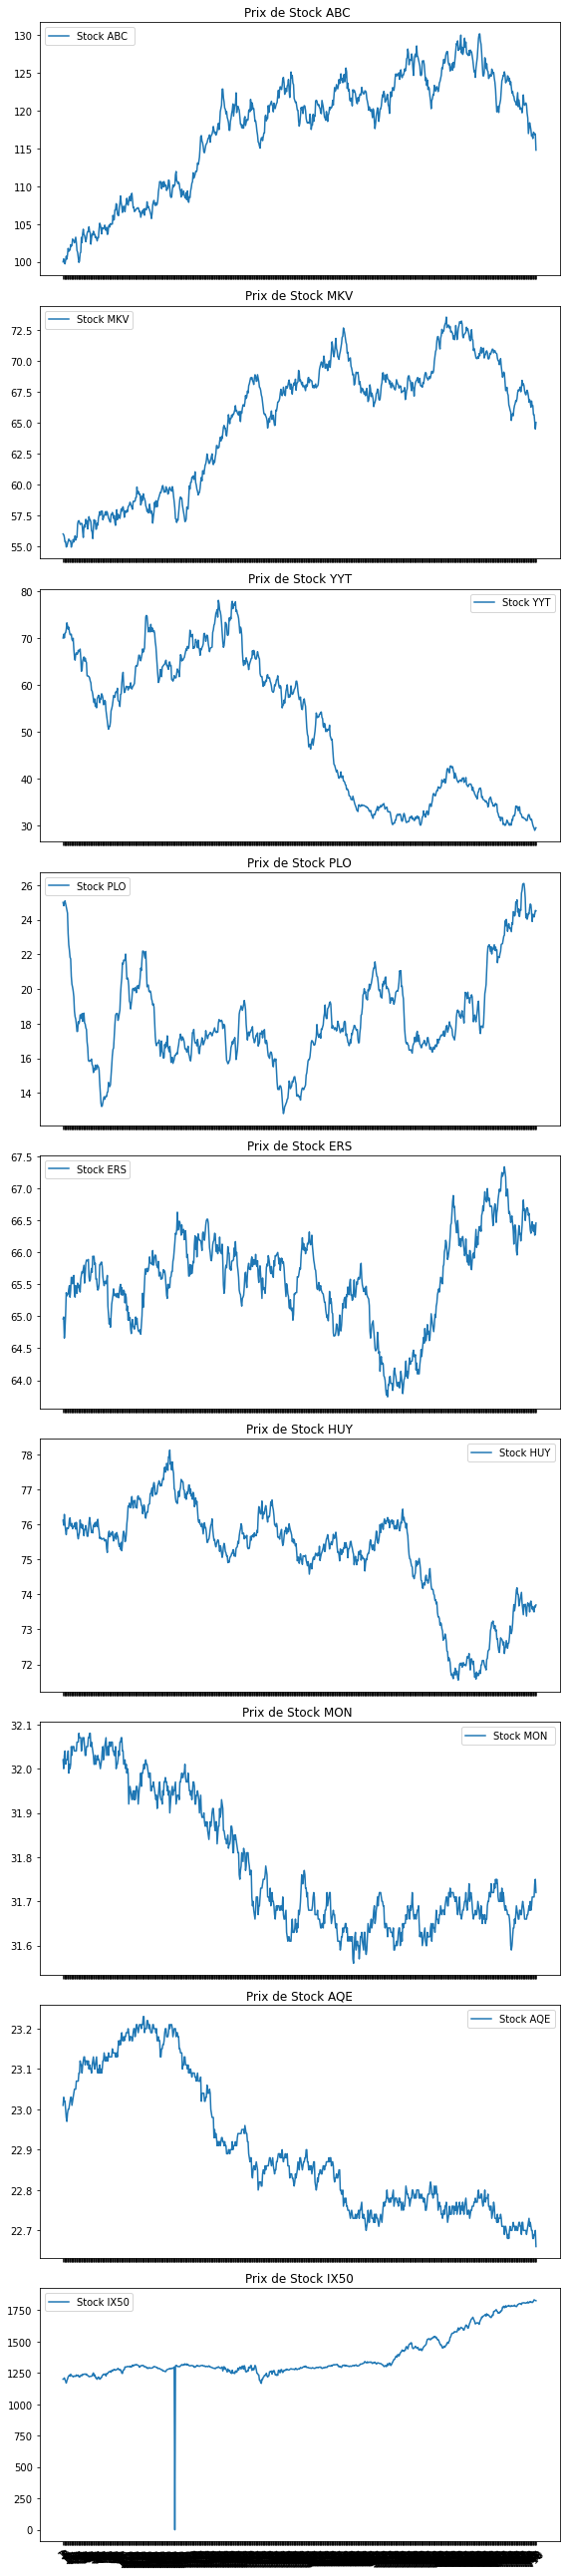

In [6]:
# Exemple de données de prix pour différentes actions
tickers = ['ABC ', 'MKV', 'YYT', 'PLO', 'ERS', 'HUY', 'MON ', 'AQE', 'IX50']
dates = data["Day"]

x = np.arange(len(dates))
n = len(tickers)  # Nombre d'actions

# Créer les sous-graphiques (subplots)
fig, ax = plt.subplots(n, 1, sharex=True, figsize=(8, 4 * n))

# Tracer les courbes de prix pour chaque action sur des sous-graphiques distincts
for i in range(n):
    ax[i].plot(x, data[tickers[i]], label=f'Stock {tickers[i]}')
    ax[i].set_title(f'Prix de Stock {tickers[i]}')
    ax[i].legend()

# Définir les étiquettes de l'axe x avec les dates
plt.xticks(x, dates, rotation=45)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()


In [7]:
# Define a threshold for outliers (e.g., z-score > 3)
outlier_threshold = 3

# Identify and store the numeric columns in your DataFrame
numeric_columns = data.select_dtypes(include=[np.number]).columns


#################### Weekday ##############################################
column_name = "Weekday"
value_to_replace = ["Thurday","thursday"]
new_value = "Thursday"
# Utilisez une boucle pour parcourir les indices de ligne
for row_index, row in data.iterrows():
    if row[column_name] in value_to_replace:
        data.at[row_index, column_name] = new_value
data = data.dropna()
data = data.interpolate()


# Iterate through the numeric columns and calculate z-scores
for column_name in numeric_columns:
    z_scores = np.abs(stats.zscore(data[column_name]))
    outlier_dates = data['Day'][z_scores > outlier_threshold]
    data = data[~data['Day'].isin(outlier_dates)]
cleaned_data = data[~data['Day'].isin(outlier_dates)]

stocks_cleaned = cleaned_data[tickers]
returns = stocks_cleaned.div(stocks_cleaned.shift(1), axis=1) -1
returns

cleaned_data = pd.concat([returns[1:], cleaned_data[["Weekday","Macro Environment"]][1:]], axis=1)


Weekday_cleaned = cleaned_data["Weekday"]
Macro_Environment_cleaned = cleaned_data["Macro Environment"]

cleaned_data.to_csv('cleaned_data.csv', index=False)
cleaned_data

ABC        MKV       YYT       PLO       ERS       HUY      MON   \
1    0.003900 -0.001071  0.011429 -0.007600  0.000462 -0.001839 -0.000625   
2   -0.003984 -0.003575 -0.011158  0.006449 -0.005078  0.004080  0.000938   
3   -0.002600 -0.006817  0.014569  0.004806  0.002320 -0.003670  0.000312   
4    0.005415  0.000542  0.001267 -0.006377  0.003240 -0.002368 -0.000936   
5    0.004687 -0.007944  0.009702 -0.007220  0.005383 -0.001582  0.000312   
..        ...       ...       ...       ...       ...       ...       ...   
745  0.007135 -0.011146 -0.012983 -0.000411 -0.000904 -0.001629  0.000000   
746 -0.000854  0.000000 -0.010455 -0.005761  0.001508 -0.000408  0.000000   
747 -0.001623 -0.009596 -0.015337  0.007036 -0.002409  0.002313  0.000946   
748  0.000599 -0.008151  0.012461  0.008631  0.000151 -0.000407  0.000315   
749 -0.018300  0.008218  0.006496 -0.001222  0.002716  0.000815 -0.000945   

          AQE      IX50    Weekday Macro Environment  
1    0.000869  0.000950    Tuesday          Positive  
2   -0.000434  0.007276  Wednesday          Positive  
3    0.000000 -0.011811   Thursday          Positive  
4   -0.000869 -0.008322     Friday          Positive  
5   -0.000870 -0.013992     Monday          Positive  
..        ...       ...        ...               ...  
745  0.000000  0.004442     Monday           Neutral  
746  0.000441  0.005794    Tuesday           Neutral  
747  0.000000 -0.001931  Wednesday           Neutral  
748  0.000441 -0.000858   Thursday           Neutral  
749 -0.001762 -0.001258     Friday           Neutral  

[747 rows x 11 columns]

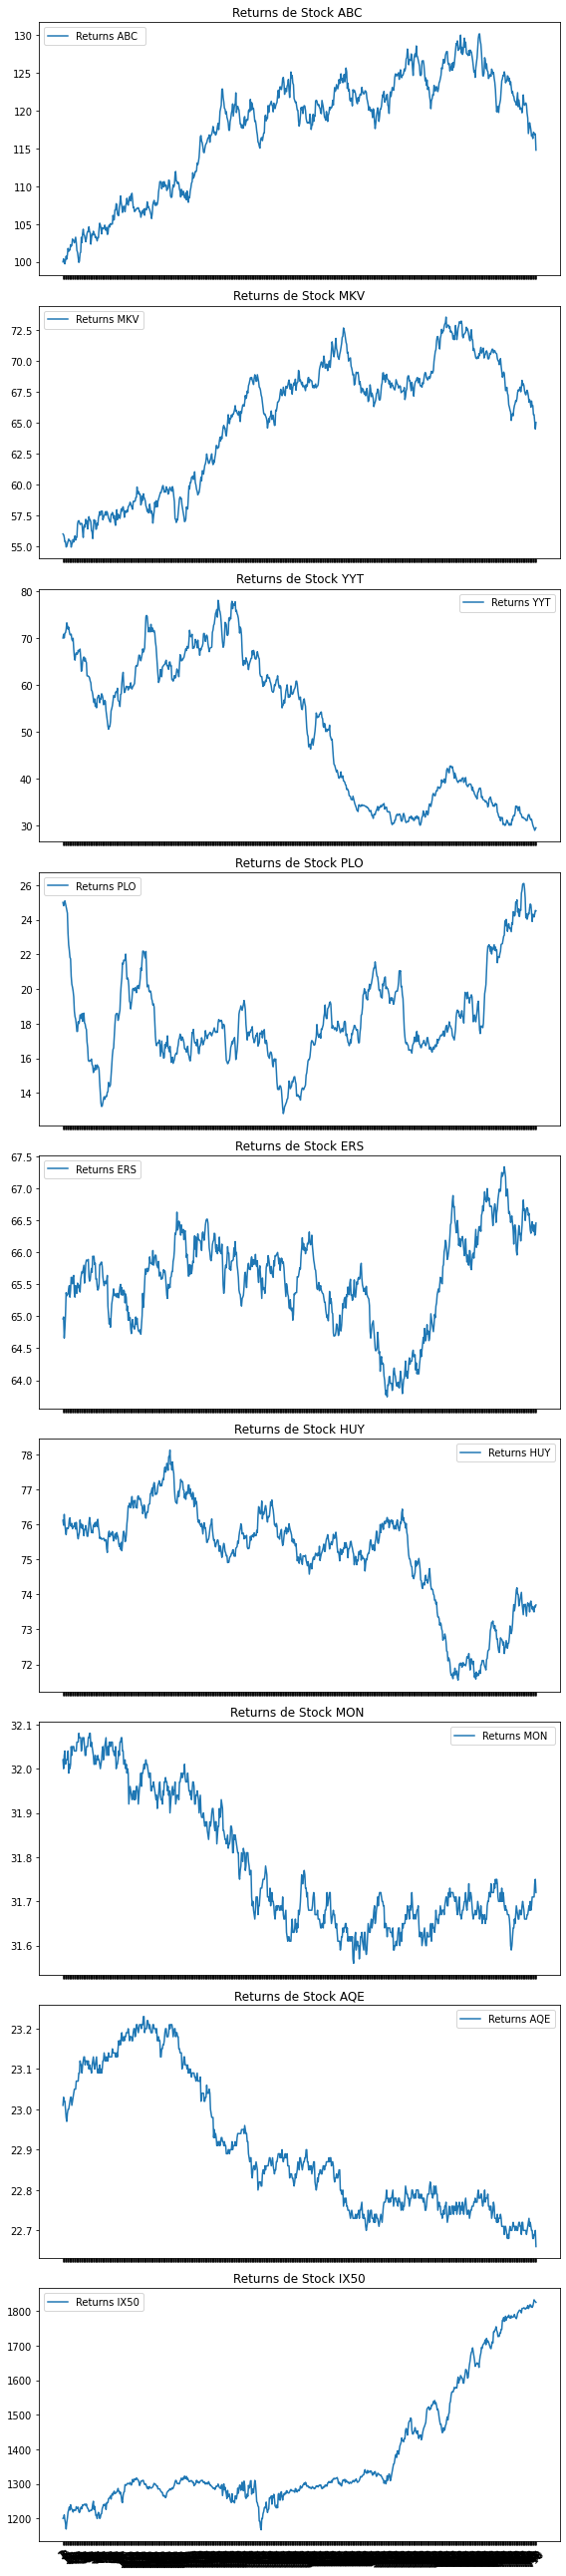

In [8]:
x = np.arange(len(stocks_cleaned))

n = len(tickers)
# Créer les sous-graphiques (subplots)
fig, ax = plt.subplots(n, 1, sharex=True, figsize=(8, 4 * n))

# Tracer les courbes de prix pour chaque action sur des sous-graphiques distincts
for i in range(n):
    ax[i].plot(x, stocks_cleaned[tickers[i]], label=f'Returns {tickers[i]}')
    ax[i].set_title(f'Returns de Stock {tickers[i]}')
    ax[i].legend()

# Définir les étiquettes de l'axe x avec les dates
plt.xticks(x, data["Day"], rotation=45)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()


 1 date has been delete as consider as an outlier according to our threshold.

## LSTM

In [11]:
def train_lstm_model(data, prediction_sample, lstm_units=50, epochs=50, batch_size=32):
    # Load your data and create input features (X) and target (y)
    # X should include your 9 stock returns and 2 dummy variables
    # y should be the target 9 stock return time series

    scaler = MinMaxScaler()

    returns_data = scaler.fit_transform(data[['ABC ', 'MKV', 'YYT', 'PLO', 'ERS', 'HUY', 'MON ', 'AQE', 'IX50']])
    weekday_data = pd.get_dummies(data['Weekday'])
    macro_environment_data = pd.get_dummies(data['Macro Environment'])
    input_features = np.column_stack((returns_data, weekday_data, macro_environment_data))

    X = input_features  # No need to use .values
    y = returns_data  # No need to use .values

    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)  # 70% train, 30% (temp)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)  # 15% validation, 15% test

    # Normalize the data (scaling between 0 and 1)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Reshape data to match LSTM input shape (samples, time steps, features)
    # Adjust the time_steps and feature dimensions according to your dataset
    time_steps = 1
    features_per_time_step = X_train.shape[1]
    X_train = X_train.reshape(X_train.shape[0], time_steps, features_per_time_step)
    X_val = X_val.reshape(X_val.shape[0], time_steps, features_per_time_step)
    X_test = X_test.reshape(X_test.shape[0], time_steps, features_per_time_step)

    # Define a function to create your LSTM model
    def create_lstm_model(lstm_units=50, optimizer='adam'):
        model = Sequential()
        model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(9, activation='linear'))
        model.add(Dense(9))  # 9 output nodes for 9 stock returns
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    # Wrap the Keras model so it can be used with Scikit-learn
    regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)

    # Define hyperparameters to search
    param_grid = {
        'lstm_units': [50, 100, 150],  # You can add more values to search
        'epochs': [50, 100, 150],
        'batch_size': [32, 64, 128]
    }

    # Create a GridSearchCV instance
    grid = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

    # Fit the grid search to find the best hyperparameters
    grid_result = grid.fit(X_train, y_train)

    # Print the best parameters and best MSE score
    best_params = grid_result.best_params_
    best_score = -grid_result.best_score_

    if prediction_sample == "test":
        # Make predictions on the test set
        y_pred_test = grid_result.predict(X_test)
        # Calculate the mean squared error as an evaluation metric
        mse = mean_squared_error(y_test, y_pred_test)
        return X_train, X_val, X_test, y_train, y_val, y_test, y_pred_test, mse, weekday_data, macro_environment_data, scaler, best_params, best_score
    
    if prediction_sample == "validation":
        # Make predictions on the validation set
        y_pred_validation = grid_result.predict(X_val)
        # Calculate the mean squared error as an evaluation metric
        mse = mean_squared_error(y_val, y_pred_validation)
        return X_train, X_val, X_test, y_train, y_val, y_test, y_pred_validation, mse, weekday_data, macro_environment_data, scaler, best_params, best_score

    if prediction_sample == "train":
        # Make predictions on the training set
        y_pred_train = grid_result.predict(X_train)
        # Calculate the mean squared error as an evaluation metric
        mse = mean_squared_error(y_train, y_pred_train)
        return X_train, X_val, X_test, y_train, y_val, y_test, y_pred_train, mse, weekday_data, macro_environment_data, scaler, best_params, best_score

# Usage example:
# data = load_your_data_function()  # Replace with your data loading function
# X_train, X_val, X_test, y_train, y_val, y_test, y_pred, mse, weekday_data, macro_environment_data, scaler, best_params, best_score = train_lstm_model(data, lstm_units=50, epochs=50, batch_size=32, prediction_sample="test")
# print(f"Mean Squared Error: {mse}")
#


In [12]:
X_train, X_val, X_test, y_train, y_val, y_test, y_pred, mse, weekday_data, macro_environment_data, scaler, best_params, best_score = train_lstm_model(data, lstm_units=50, epochs=50, batch_size=32, prediction_sample="test")


<ipython-input-11-6dd4b3b16655>:45: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)


In [20]:
X_train, X_val, X_test, y_train, y_val, y_test, y_pred, mse, weekday_data, macro_environment_data, scaler = train_lstm_model(cleaned_data, prediction_sample="train", lstm_units=50, epochs=50, batch_size=32)

Epoch 1/50
17/17 [==============================] - 4s 66ms/step - loss: 0.2678 - val_loss: 0.2042
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.1505 - val_loss: 0.0991
Epoch 3/50
17/17 [==============================] - 0s 7ms/step - loss: 0.0758 - val_loss: 0.0602
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.0503 - val_loss: 0.0412
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0362 - val_loss: 0.0286
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0269 - val_loss: 0.0201
Epoch 7/50
17/17 [==============================] - 0s 7ms/step - loss: 0.0210 - val_loss: 0.0169
Epoch 8/50
17/17 [==============================] - 0s 5ms/step - loss: 0.0194 - val_loss: 0.0168
Epoch 9/50
17/17 [==============================] - 0s 6ms/step - loss: 0.0189 - val_loss: 0.0162
Epoch 10/50
17/17 [==============================] - 0s 5ms/step - loss: 0.0184 - val_loss: 0.0158
Epoch 11/50
17/17 

In [41]:
def plot_stock_predictions(cleaned_data, prediction_sample,use_returns=False):
    #choose sample from train, validtion and test
    X_train, X_val, X_test, y_train, y_val, y_test, y_pred, mse, weekday_data, macro_environment_data, scaler, best_params, best_score = train_lstm_model(data, lstm_units=50, epochs=50, batch_size=32, prediction_sample=prediction_sample)
    
    if prediction_sample == "test" : 

        if use_returns:
            output_features_pred = np.column_stack((y_pred, weekday_data[len(weekday_data) - len(y_pred)::], macro_environment_data[len(weekday_data) - len(y_pred)::]))
            output_features_test = np.column_stack((y_test, weekday_data[len(weekday_data) - len(y_test)::], macro_environment_data[len(weekday_data) - len(y_test)::]))
            output_features_pred = scaler.inverse_transform(output_features_pred)
            output_features_test = scaler.inverse_transform(output_features_test)

            returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
            returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]

            data_test = returns_test
            data_pred = returns_pred

            time_range = [i for i in range(1, len(y_test))]  # Exclude the first time step for returns
        else:
            data_test = y_test
            data_pred = y_pred
            time_range = [i for i in range(len(y_test))]

        plt.figure(figsize=(15, 15))

        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.plot(time_range, data_test[:, i], label=f'Actual Stock Return {i + 1}', marker='o', linestyle='-')
            plt.plot(time_range, data_pred[:, i], label=f'Predicted Stock Return {i + 1}', marker='o', linestyle='--')
            plt.title(f'Stock Return {i + 1}')
            plt.xlabel('Time Steps')
            plt.ylabel('Stock Return')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()

        # Show the subplots
        plt.show()

        return data_pred
    
    if prediction_sample == "validation" : 
        if use_returns:
            output_features_pred = np.column_stack((y_pred, weekday_data[len(weekday_data) - 2*len(y_pred):len(weekday_data) - len(y_pred)], macro_environment_data[len(weekday_data) - 2*len(y_pred):len(weekday_data) - len(y_pred)]))
            output_features_test = np.column_stack((y_val, weekday_data[len(weekday_data) - 2*len(y_val):len(weekday_data) - len(y_val)], macro_environment_data[len(weekday_data) - 2*len(y_val):len(weekday_data) - len(y_val)]))
            output_features_pred = scaler.inverse_transform(output_features_pred)
            output_features_test = scaler.inverse_transform(output_features_test)

            returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
            returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]

            data_test = returns_test
            data_pred = returns_pred

            time_range = [i for i in range(1, len(y_val))]  # Exclude the first time step for returns
        else:
            data_test = y_val
            data_pred = y_pred
            time_range = [i for i in range(len(y_val))]

        plt.figure(figsize=(15, 15))

        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.plot(time_range, data_test[:, i], label=f'Actual Stock Return {i + 1}', marker='o', linestyle='-')
            plt.plot(time_range, data_pred[:, i], label=f'Predicted Stock Return {i + 1}', marker='o', linestyle='--')
            plt.title(f'Stock Return {i + 1}')
            plt.xlabel('Time Steps')
            plt.ylabel('Stock Return')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()

        # Show the subplots
        plt.show()

        return data_pred
    
    if prediction_sample == "train" : 
        if use_returns:
            output_features_pred = np.column_stack((y_pred, weekday_data[:len(y_pred)], macro_environment_data[:len(y_pred)]))
            output_features_test = np.column_stack((y_train, weekday_data[:len(y_train)], macro_environment_data[:len(y_train)]))
            output_features_pred = scaler.inverse_transform(output_features_pred)
            output_features_test = scaler.inverse_transform(output_features_test)

            returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
            returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]

            data_test = returns_test
            data_pred = returns_pred

            time_range = [i for i in range(1, len(y_train))]  # Exclude the first time step for returns
        else:
            data_test = y_train
            data_pred = y_pred
            time_range = [i for i in range(len(y_train))]

        plt.figure(figsize=(15, 15))
        
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.plot(time_range, data_test[:, i], label=f'Actual Stock Return {i + 1}', marker='o', linestyle='-')
            plt.plot(time_range, data_pred[:, i], label=f'Predicted Stock Return {i + 1}', marker='o', linestyle='--')
            plt.title(f'Stock Return {i + 1}')
            plt.xlabel('Time Steps')
            plt.ylabel('Stock Return')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()

        # Show the subplots
        plt.show()

        return data_pred


# Use the function with your choice
# plot_stock_predictions(y_test, y_pred)  # To plot stock values
# plot_stock_predictions(y_test, y_pred, use_returns=True)  # To plot returns


<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:89: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:89: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:90: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:90: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


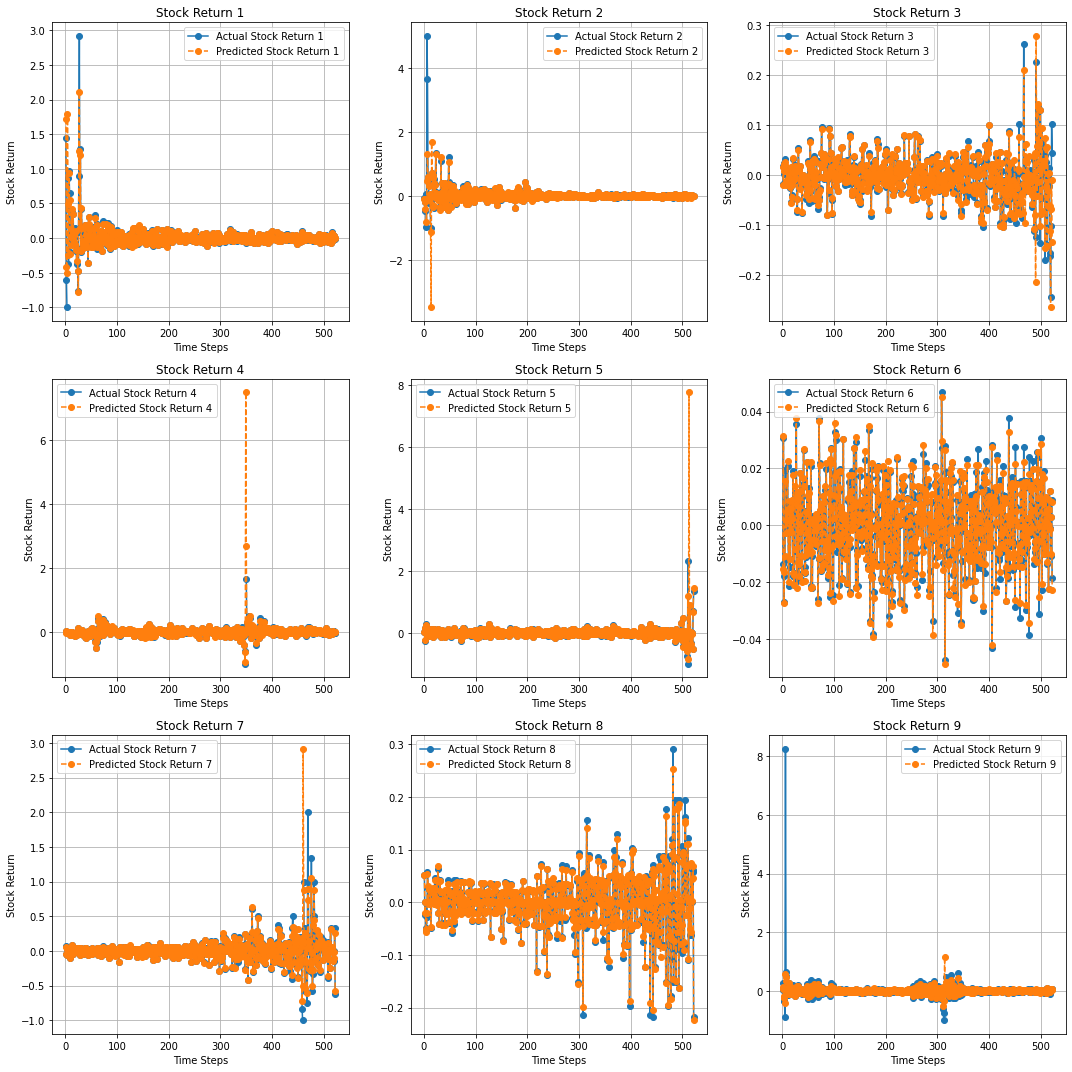

In [46]:
return_pred = plot_stock_predictions(cleaned_data,prediction_sample = "train", use_returns=True)
stock_returns_pred = return_pred[:,:9]
sample_test_stock_prices = data[tickers][len(data)-len(stock_returns_pred):].values
sample_validation_stock_prices = data[tickers][len(data)-2*len(stock_returns_pred):len(stock_returns_pred)].values

In [47]:
def stock_prices_sample(data, prediction_sample): 
    tickers = ['ABC ', 'MKV', 'YYT', 'PLO', 'ERS', 'HUY', 'MON ', 'AQE', 'IX50']
    return_pred = plot_stock_predictions(cleaned_data,prediction_sample = prediction_sample, use_returns=True)
    stock_returns_pred = return_pred[:,:9]
    
    if prediction_sample == "test":
        return data[tickers][len(data)-len(stock_returns_pred):].values
    
    if prediction_sample == "validation":
        return data[tickers][len(data)-2*len(stock_returns_pred):len(data)-len(stock_returns_pred)].values
    
    if prediction_sample == "train":
        return data[tickers][:len(data)-2*len(stock_returns_pred)].values

In [48]:
def optimize_portfolio(initial_cash, prediction_sample, tickers):
    return_pred = plot_stock_predictions(cleaned_data,prediction_sample = prediction_sample, use_returns=True)
    predictions = return_pred[:,:9]
    
    stock_prices = stock_prices_sample(data=data, prediction_sample=prediction_sample)
    num_days = stock_prices.shape[0]    
    
    portfolio = {}  # Initialize an empty portfolio
    cash = initial_cash  # Start with the initial cash

    # Initialize the portfolio with equal weight
    num_stocks = len(tickers)
    equal_weight = initial_cash / num_stocks

    for ticker in tickers:
        portfolio[ticker] = {'shares': int(equal_weight / stock_prices[0, tickers.index(ticker)]), 'price': stock_prices[0, tickers.index(ticker)]}

    # Calculate the remaining cash after distributing the equal weight
    remaining_cash = initial_cash - sum(portfolio[ticker]['shares'] * portfolio[ticker]['price']  for ticker in portfolio)

    # Initialize the cash portfolio with the remaining cash
    cash_portfolio = {'cash': remaining_cash}

    # Calculate the total portfolio value
    total_portfolio_value = sum(portfolio[ticker]['shares'] * portfolio[ticker]['price'] for ticker in portfolio) + cash_portfolio['cash']

    # Print the portfolio details
    print("Initial Portfolio:")
    for ticker in portfolio:
        print(f"{ticker}: {portfolio[ticker]['shares']} shares at ${portfolio[ticker]['price']} per share")
    print(f"Cash: ${cash_portfolio['cash']:.2f}")
    print(f"Total Portfolio Value: ${total_portfolio_value:.2f}")

    cash = remaining_cash
    portfolio_values = []

    for day in range(num_days-1):
        # Calculate the portfolio value at the beginning of the day
        portfolio_value = cash
        for ticker, stock_data in portfolio.items():
            stock_data['price'] = stock_prices[day, tickers.index(ticker)]
            stock_price = stock_data['price']
            stock_shares = stock_data['shares']
            portfolio_value += stock_price * stock_shares
        
        threshold = 0.03
        # Check if there are stocks with negative returns for the next day
        stocks_to_sell = [ticker for ticker, stock_data in portfolio.items() if predictions[day + 1][tickers.index(ticker)] < threshold]

        # Sell stocks with negative returns
        for ticker in stocks_to_sell:
            stock_price = portfolio[ticker]['price']
            stock_shares = portfolio[ticker]['shares']
            cash += stock_price * stock_shares
            del portfolio[ticker]  # Remove the sold stock from the portfolio

        # Calculate the maximum predicted return for the next day and the corresponding stock
        max_return = max(predictions[day + 1])
        stock_to_buy = tickers[predictions[day + 1].tolist().index(max_return)]

        # Calculate the number of shares to buy based on the available cash
        stock_price = stock_prices[day, tickers.index(stock_to_buy)]
        max_buyable_shares = cash // stock_price

        # Buy shares
        buy_shares = min(max_buyable_shares, cash // stock_price)
        cash -= stock_price * buy_shares
        if stock_to_buy in portfolio:
            portfolio[stock_to_buy]['shares'] += buy_shares
        else:
            portfolio[stock_to_buy] = {'shares': buy_shares, 'price': stock_price}
        
        # Print the portfolio value for each day
        print(f"Day {day + 1} - Portfolio Value: ${portfolio_value:.2f}")
        portfolio_values.append(portfolio_value)

    # Calculate the final portfolio value
    final_portfolio_value = cash
    for ticker, stock_data in portfolio.items():
        final_portfolio_value += stock_data['price'] * stock_data['shares']
    
    # Print the final portfolio value
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
        
    days = list(range(1, num_days))

    plt.figure(figsize=(10, 6))
    plt.plot(days, portfolio_values, marker='o', linestyle='-', color='b')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Day')
    plt.ylabel('Portfolio Value')
    plt.grid(True)

    # Show the plot
    plt.show()
    return(portfolio_values)
# Use the function with your desired minimum_cash, stock_prices, predictions, and tickers
# optimize_portfolio(minimum_cash, stock_prices, predictions, tickers)


<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:13: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:13: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:14: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:14: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


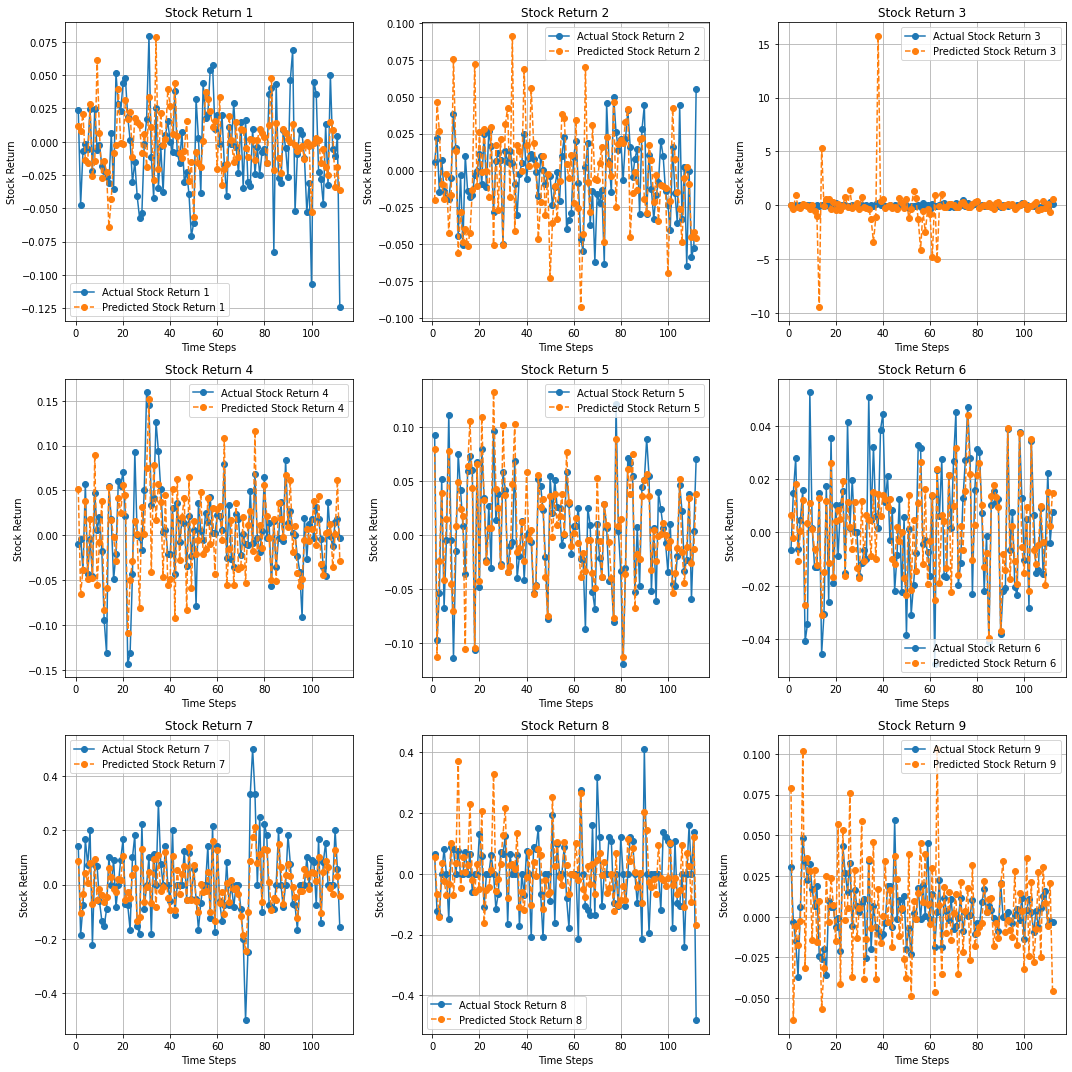

<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:13: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:13: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:14: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:14: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


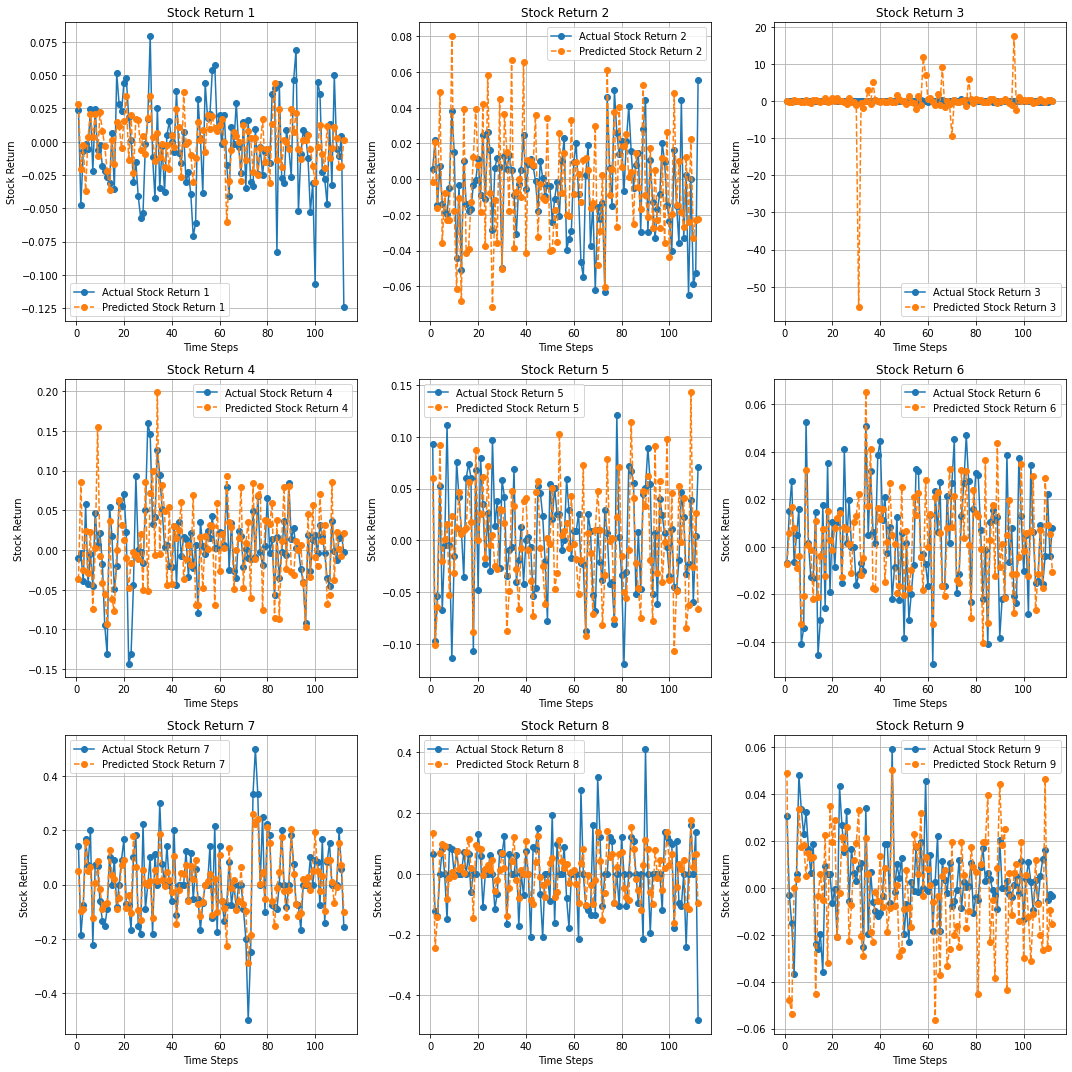

Initial Portfolio:
ABC : 860 shares at $129.1 per share
MKV: 1535 shares at $72.34 per share
YYT: 2765 shares at $40.18 per share
PLO: 5628 shares at $19.74 per share
ERS: 1678 shares at $66.21 per share
HUY: 1544 shares at $71.96 per share
MON : 3502 shares at $31.72 per share
AQE: 4877 shares at $22.78 per share
IX50: 68 shares at $1631.26 per share
Cash: $423.88
Total Portfolio Value: $1000000.00
Day 1 - Portfolio Value: $1000000.00
Day 2 - Portfolio Value: $1005252.74
Day 3 - Portfolio Value: $1001613.44
Day 4 - Portfolio Value: $1002245.76
Day 5 - Portfolio Value: $1002561.92
Day 6 - Portfolio Value: $1003510.40
Day 7 - Portfolio Value: $1007017.90
Day 8 - Portfolio Value: $1007460.93
Day 9 - Portfolio Value: $1016463.17
Day 10 - Portfolio Value: $1007284.77
Day 11 - Portfolio Value: $1007727.53
Day 12 - Portfolio Value: $1009104.17
Day 13 - Portfolio Value: $1009104.17
Day 14 - Portfolio Value: $1007479.67
Day 15 - Portfolio Value: $1009466.72
Day 16 - Portfolio Value: $1012065.0

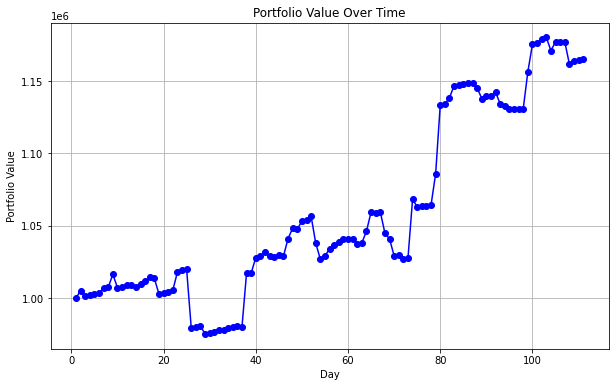

In [49]:
portoflio_optimized = optimize_portfolio(initial_cash=1000000, prediction_sample="test" , tickers = tickers)

In [50]:
def compute_portfolio_metrics(risk_free_rate, initial_cash_):
    tickers = ['ABC ', 'MKV', 'YYT', 'PLO', 'ERS', 'HUY', 'MON ', 'AQE', 'IX50']
    sample = ["test", "validation", "train"]

    stock_prices_df = pd.DataFrame(data=data[tickers][:].values, columns=tickers)

    returns_test_pred = plot_stock_predictions(cleaned_data, prediction_sample=sample[0], use_returns=True)
    returns_validation_pred = plot_stock_predictions(cleaned_data, prediction_sample=sample[1], use_returns=True)
    returns_train_pred = plot_stock_predictions(cleaned_data, prediction_sample=sample[2], use_returns=True)

    portfolio_test_value = optimize_portfolio(initial_cash=initial_cash_, prediction_sample=sample[0], tickers=tickers)
    portfolio_validation_value = optimize_portfolio(initial_cash=initial_cash_, prediction_sample=sample[1], tickers=tickers)
    portfolio_train_value = optimize_portfolio(initial_cash=initial_cash_, prediction_sample=sample[2], tickers=tickers)

    # Calculate the time period for one day
    one_day = pd.DateOffset(days=1)

    # Convert the portfolio value to a DataFrame with dates
    portfolio_test_df = pd.DataFrame(data={'Portfolio Value': portfolio_test_value}, index=pd.date_range(start=0, periods=len(portfolio_test_value), freq=one_day))
    portfolio_validation_df = pd.DataFrame(data={'Portfolio Value': portfolio_validation_value}, index=pd.date_range(start=0, periods=len(portfolio_validation_value), freq=one_day))
    portfolio_train_df = pd.DataFrame(data={'Portfolio Value': portfolio_train_value}, index=pd.date_range(start=0, periods=len(portfolio_train_value), freq=one_day))

    # Calculate the daily returns of the portfolio
    portfolio_test_df['Daily Return'] = portfolio_test_df['Portfolio Value'].pct_change()
    portfolio_validation_df['Daily Return'] = portfolio_validation_df['Portfolio Value'].pct_change()
    portfolio_train_df['Daily Return'] = portfolio_train_df['Portfolio Value'].pct_change()

    # Calculate the annualized expected return
    average_annualized_return_test = ((portfolio_test_df['Portfolio Value'][-1] / portfolio_test_df['Portfolio Value'][0]) ** (252 / len(portfolio_test_df.index))) - 1
    average_annualized_return_validation = ((portfolio_validation_df['Portfolio Value'][-1] / portfolio_validation_df['Portfolio Value'][0]) ** (252 / len(portfolio_validation_df.index))) - 1
    average_annualized_return_train = ((portfolio_train_df['Portfolio Value'][-1] / portfolio_train_df['Portfolio Value'][0]) ** (252 / len(portfolio_train_df.index))) - 1

    # Calculate the annualized Sharpe ratio on test data
    daily_risk_free_rate = (1 + risk_free_rate) ** (1 / 252) - 1
    excess_returns = portfolio_test_df['Daily Return'] - daily_risk_free_rate
    annualized_sharpe_ratio_test = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)
    # Calculate the annualized Sharpe ratio on validation data
    excess_returns = portfolio_validation_df['Daily Return'] - daily_risk_free_rate
    annualized_sharpe_ratio_validation = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)
    # Calculate the annualized Sharpe ratio on train data
    excess_returns = portfolio_train_df['Daily Return'] - daily_risk_free_rate
    annualized_sharpe_ratio_train = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)

    # Calculate the maximum drawdown on a 6-month period - test
    six_month_period = pd.DateOffset(months=6)
    portfolio_df_6m = portfolio_test_df
    portfolio_max_value = portfolio_df_6m['Portfolio Value'].cummax()
    portfolio_test_drawdown = (portfolio_df_6m['Portfolio Value'] - portfolio_max_value) / portfolio_max_value
    max_drawdown_test = portfolio_test_drawdown.min()
    # Calculate the maximum drawdown on a 6-month period - validation
    six_month_period = pd.DateOffset(months=6)
    portfolio_df_6m = portfolio_validation_df
    portfolio_max_value = portfolio_df_6m['Portfolio Value'].cummax()
    portfolio_test_drawdown_validation = (portfolio_df_6m['Portfolio Value'] - portfolio_max_value) / portfolio_max_value
    max_drawdown_validation = portfolio_test_drawdown_validation.min()

    # Calculate cumulative returns on validation and test data
    validation_returns = portfolio_validation_df[portfolio_validation_df.index >= portfolio_validation_df.index[0]]['Portfolio Value']
    test_returns = portfolio_test_df[portfolio_test_df.index >= portfolio_test_df.index[0]]['Portfolio Value']
    cumulative_return_validation = (validation_returns[-1] / validation_returns[0]) - 1
    cumulative_return_test = (test_returns[-1] / test_returns[0]) - 1

    # Calculate the correlation of your portfolio with equally weighted market portfolio
    market_returns = stock_prices_df.loc[len(stock_prices_df)-len(portfolio_test_df):, tickers].pct_change().sum(axis=1)
    market_returns = market_returns.dropna()

    portfolio_returns = portfolio_test_df['Daily Return']
    portfolio_returns = portfolio_returns.dropna()
    correlation, _ = pearsonr(portfolio_returns[:min(len(portfolio_returns),len(market_returns))], market_returns[:min(len(portfolio_returns),len(market_returns))])

    return {
        'Average Annualized Expected Return - test': average_annualized_return_test,
        'Average Annualized Expected Return - validation' :average_annualized_return_validation,
        'Average Annualized Expected Return - train' : average_annualized_return_train,            
        'Annualized Sharpe Ratio - test': annualized_sharpe_ratio_test,
        'Annualized Sharpe Ratio - validation': annualized_sharpe_ratio_validation,
        'Annualized Sharpe Ratio - train':annualized_sharpe_ratio_train,
        'Maximum Drawdown on 6 Months - test': max_drawdown_test,
        'Maximum Drawdown on 6 Months - validation': max_drawdown_validation,
        'Cumulative Return on Validation': cumulative_return_validation ,
        'Cumulative Return on Test': cumulative_return_test,
        'Correlation with Equally Weighted Market Portfolio': correlation
    }


<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:13: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:13: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:14: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:14: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


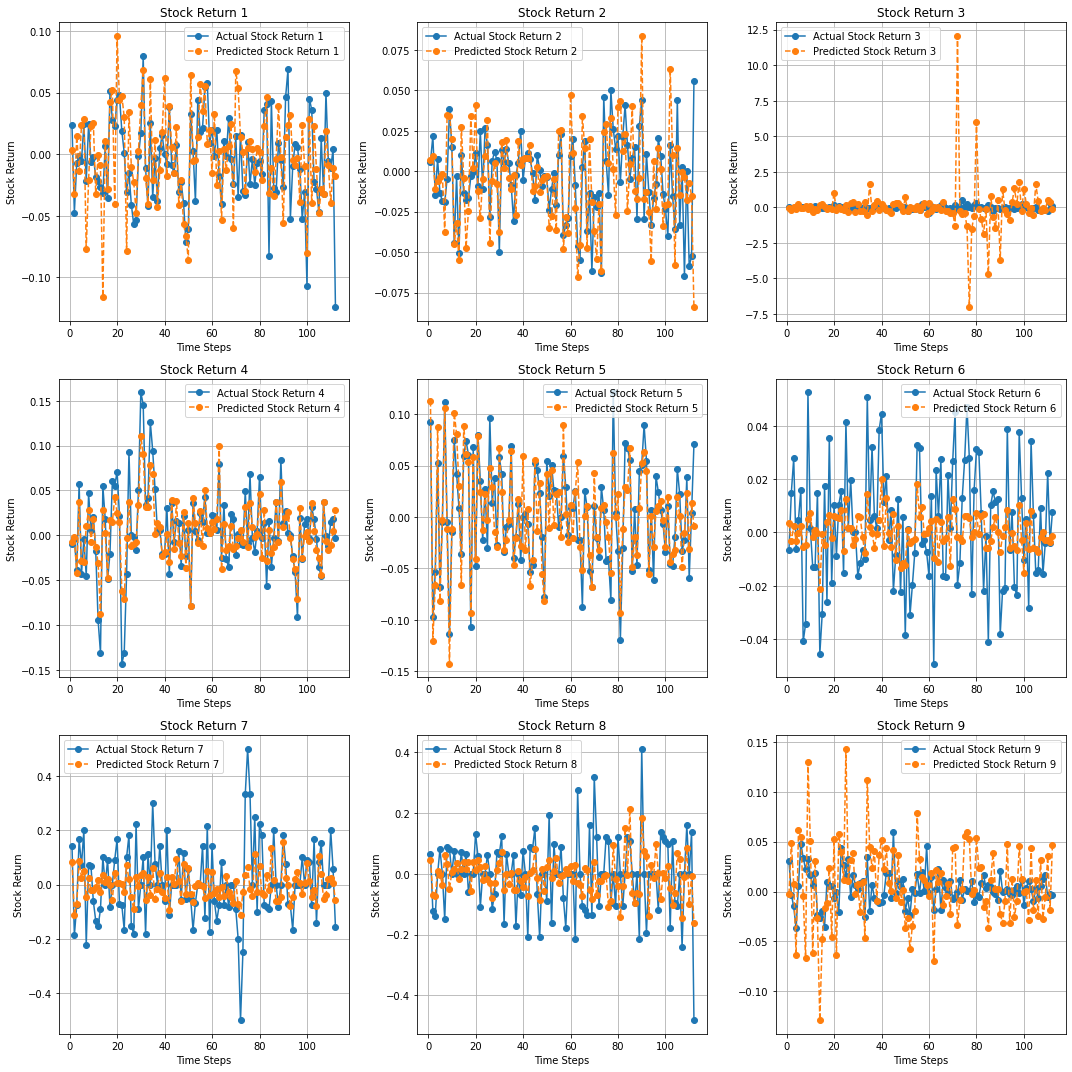

<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:51: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:51: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:52: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:52: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


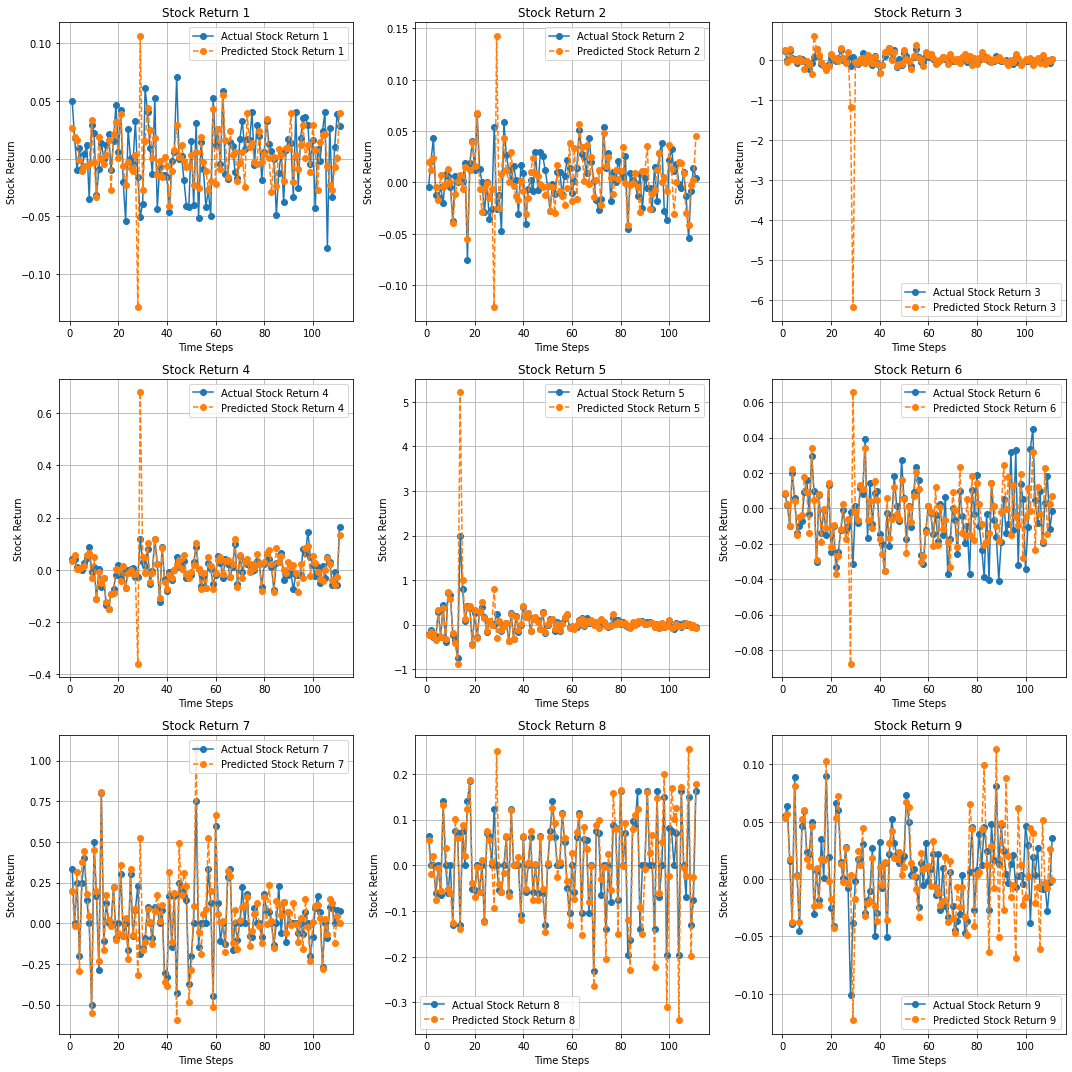

<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:89: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:89: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:90: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:90: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


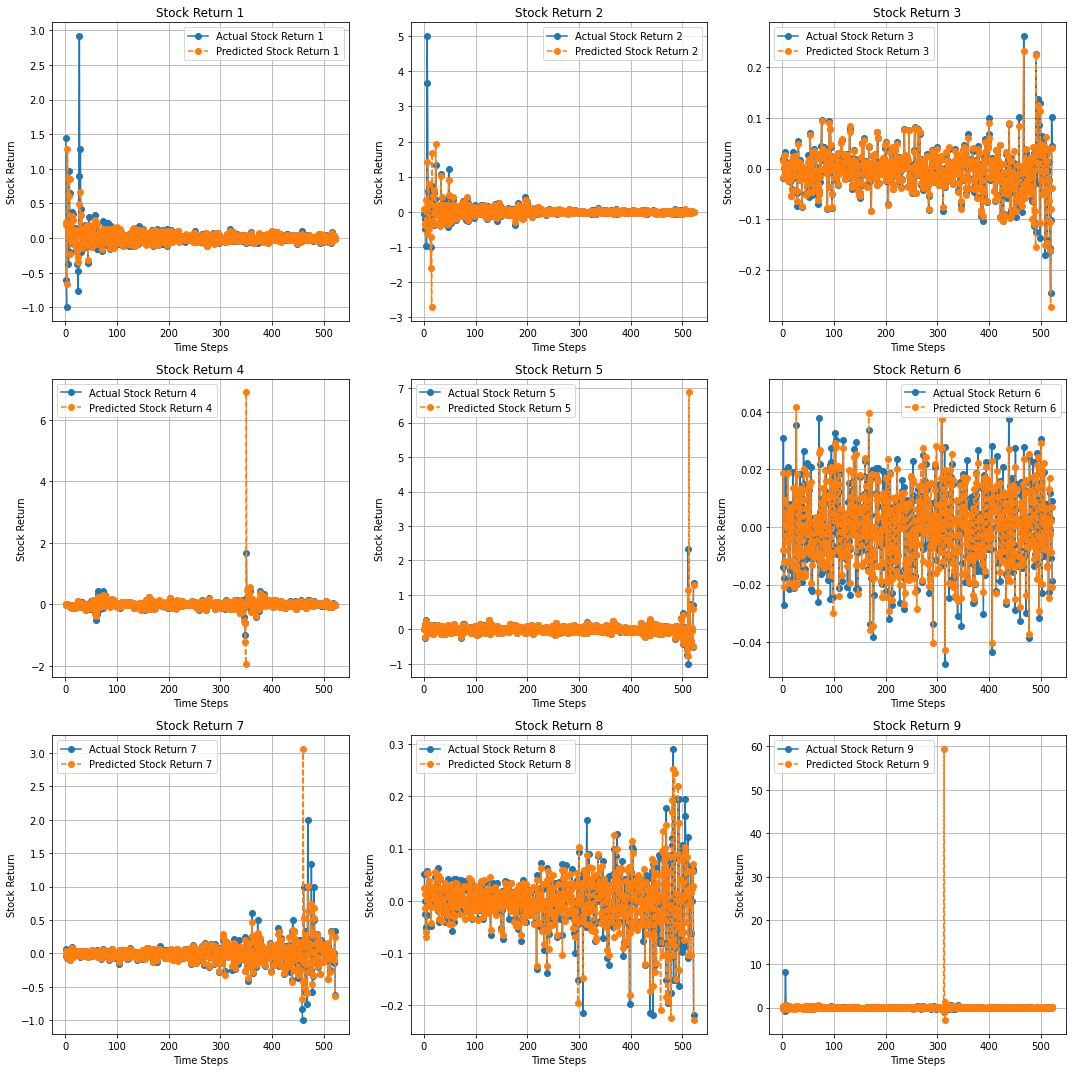

<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:13: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:13: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:14: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:14: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


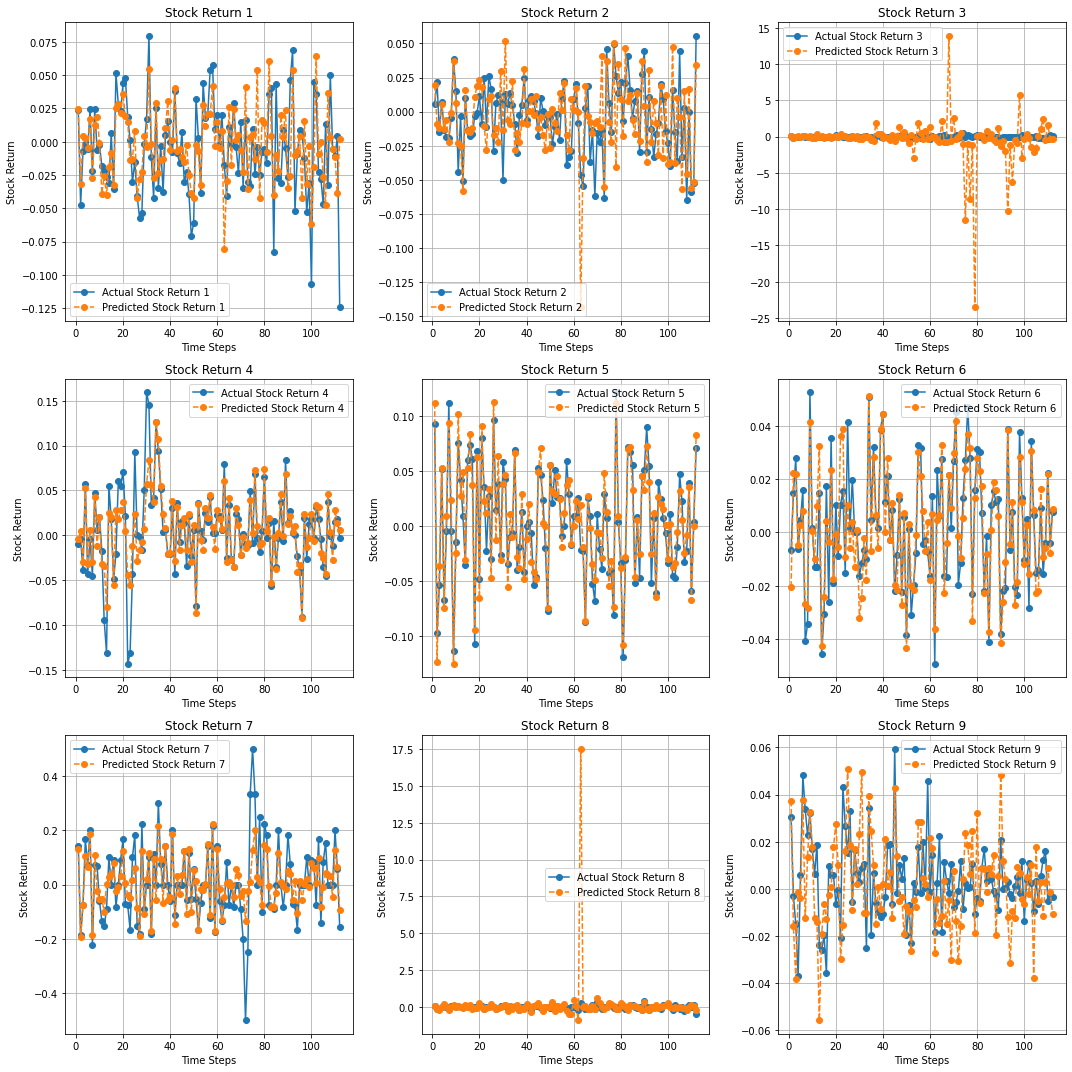

<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:13: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:13: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:14: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:14: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


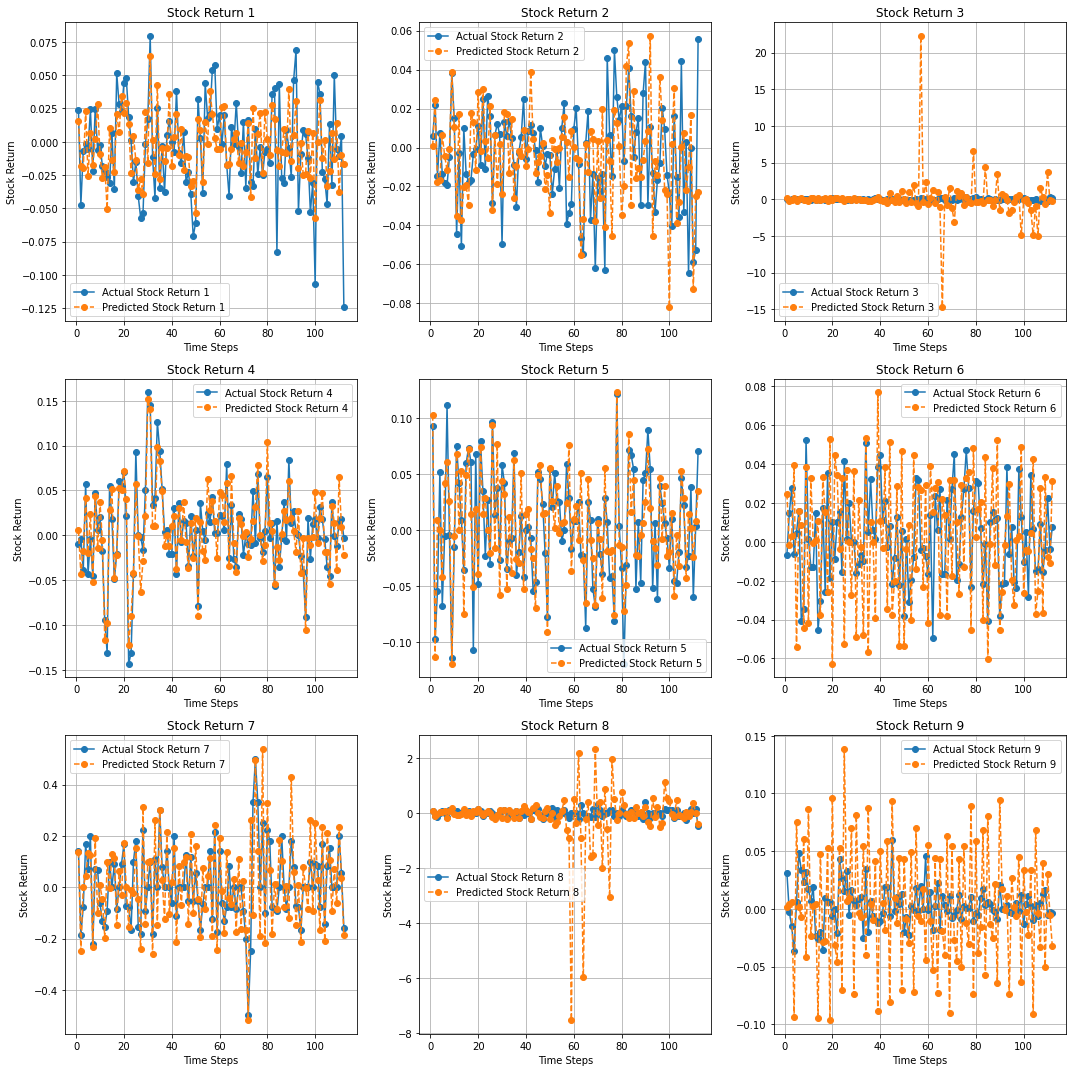

Initial Portfolio:
ABC : 860 shares at $129.1 per share
MKV: 1535 shares at $72.34 per share
YYT: 2765 shares at $40.18 per share
PLO: 5628 shares at $19.74 per share
ERS: 1678 shares at $66.21 per share
HUY: 1544 shares at $71.96 per share
MON : 3502 shares at $31.72 per share
AQE: 4877 shares at $22.78 per share
IX50: 68 shares at $1631.26 per share
Cash: $423.88
Total Portfolio Value: $1000000.00
Day 1 - Portfolio Value: $1000000.00
Day 2 - Portfolio Value: $1001250.64
Day 3 - Portfolio Value: $1003612.96
Day 4 - Portfolio Value: $1004246.54
Day 5 - Portfolio Value: $1004563.33
Day 6 - Portfolio Value: $1005513.70
Day 7 - Portfolio Value: $1009028.33
Day 8 - Portfolio Value: $1009346.63
Day 9 - Portfolio Value: $1009790.49
Day 10 - Portfolio Value: $1009790.49
Day 11 - Portfolio Value: $1010234.35
Day 12 - Portfolio Value: $1027493.87
Day 13 - Portfolio Value: $1027805.37
Day 14 - Portfolio Value: $1028256.95
Day 15 - Portfolio Value: $1028256.95
Day 16 - Portfolio Value: $1028708.5

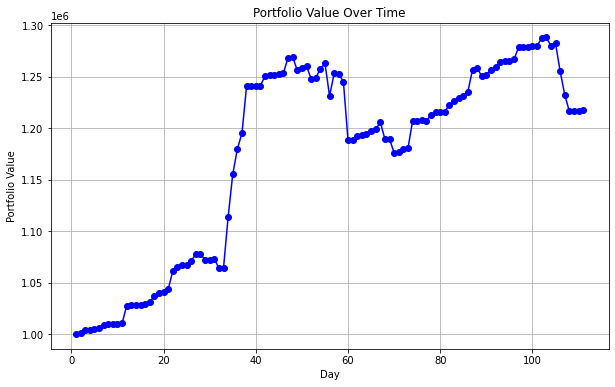

<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:51: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:51: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:52: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:52: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


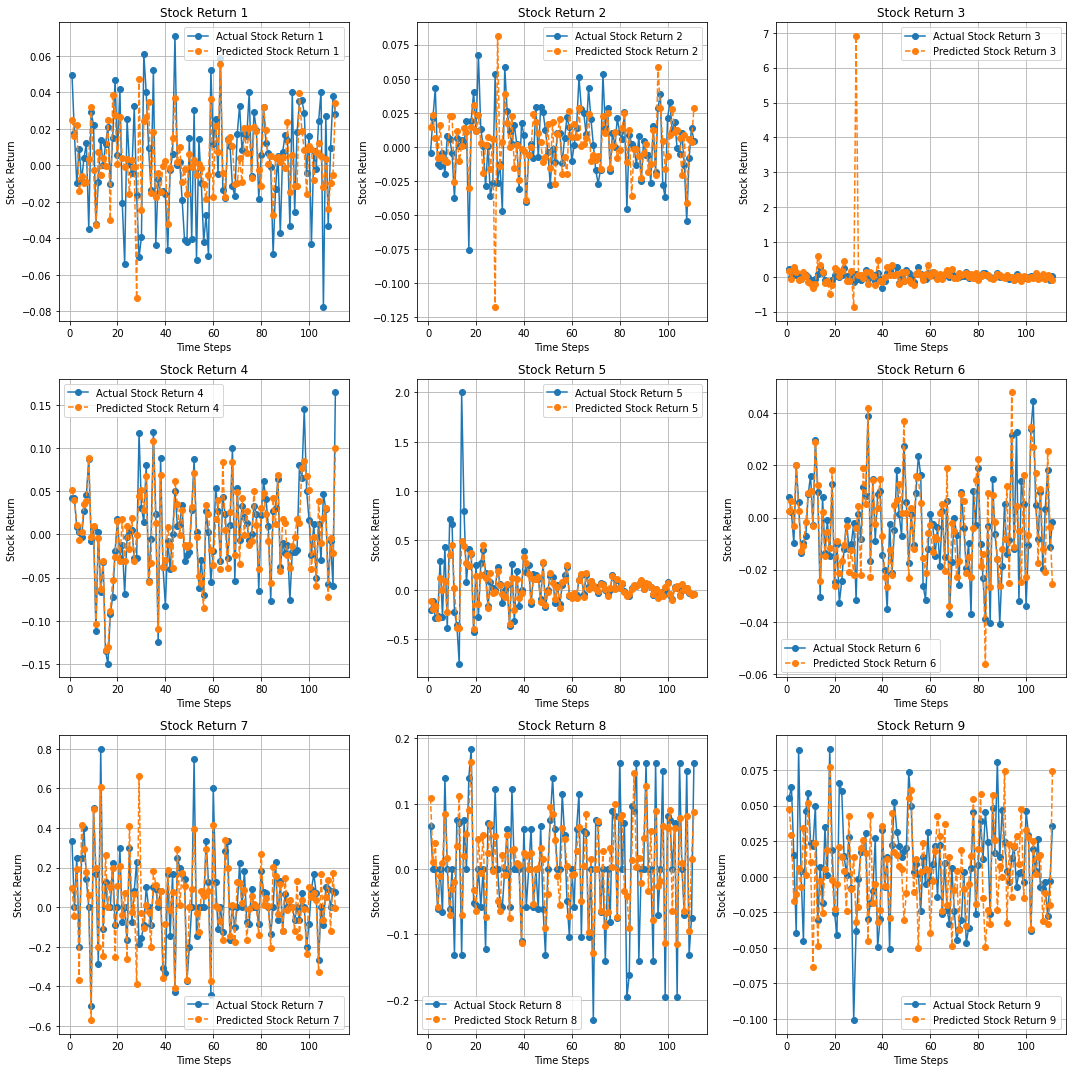

<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:51: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:51: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:52: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:52: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


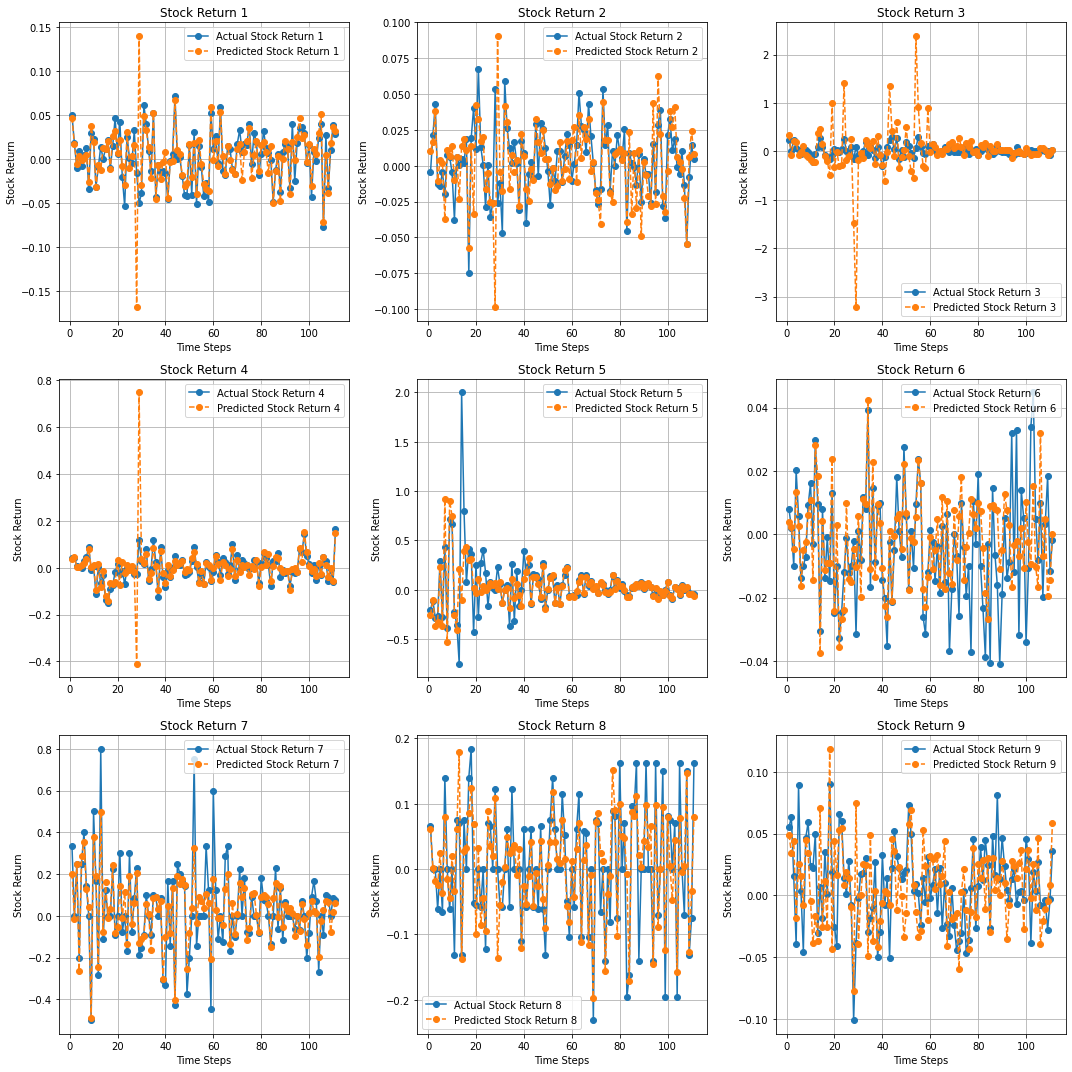

Initial Portfolio:
ABC : 891 shares at $124.64 per share
MKV: 1622 shares at $68.48 per share
YYT: 3479 shares at $31.93 per share
PLO: 5591 shares at $19.87 per share
ERS: 1736 shares at $63.97 per share
HUY: 1464 shares at $75.87 per share
MON : 3515 shares at $31.61 per share
AQE: 4877 shares at $22.78 per share
IX50: 80 shares at $1384.9 per share
Cash: $568.75
Total Portfolio Value: $1000000.00
Day 1 - Portfolio Value: $1000000.00
Day 2 - Portfolio Value: $1001006.54
Day 3 - Portfolio Value: $1005981.90
Day 4 - Portfolio Value: $996964.06
Day 5 - Portfolio Value: $997279.25
Day 6 - Portfolio Value: $997279.25
Day 7 - Portfolio Value: $996018.49
Day 8 - Portfolio Value: $996648.87
Day 9 - Portfolio Value: $995250.45
Day 10 - Portfolio Value: $993541.25
Day 11 - Portfolio Value: $994798.49
Day 12 - Portfolio Value: $993924.73
Day 13 - Portfolio Value: $994361.61
Day 14 - Portfolio Value: $994672.29
Day 15 - Portfolio Value: $996536.37
Day 16 - Portfolio Value: $998866.47
Day 17 - Po

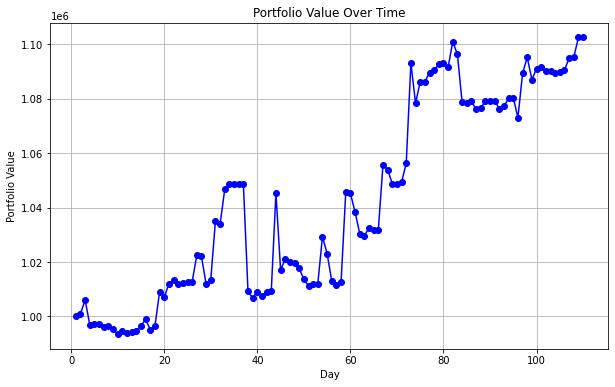

<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:89: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:89: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:90: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:90: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


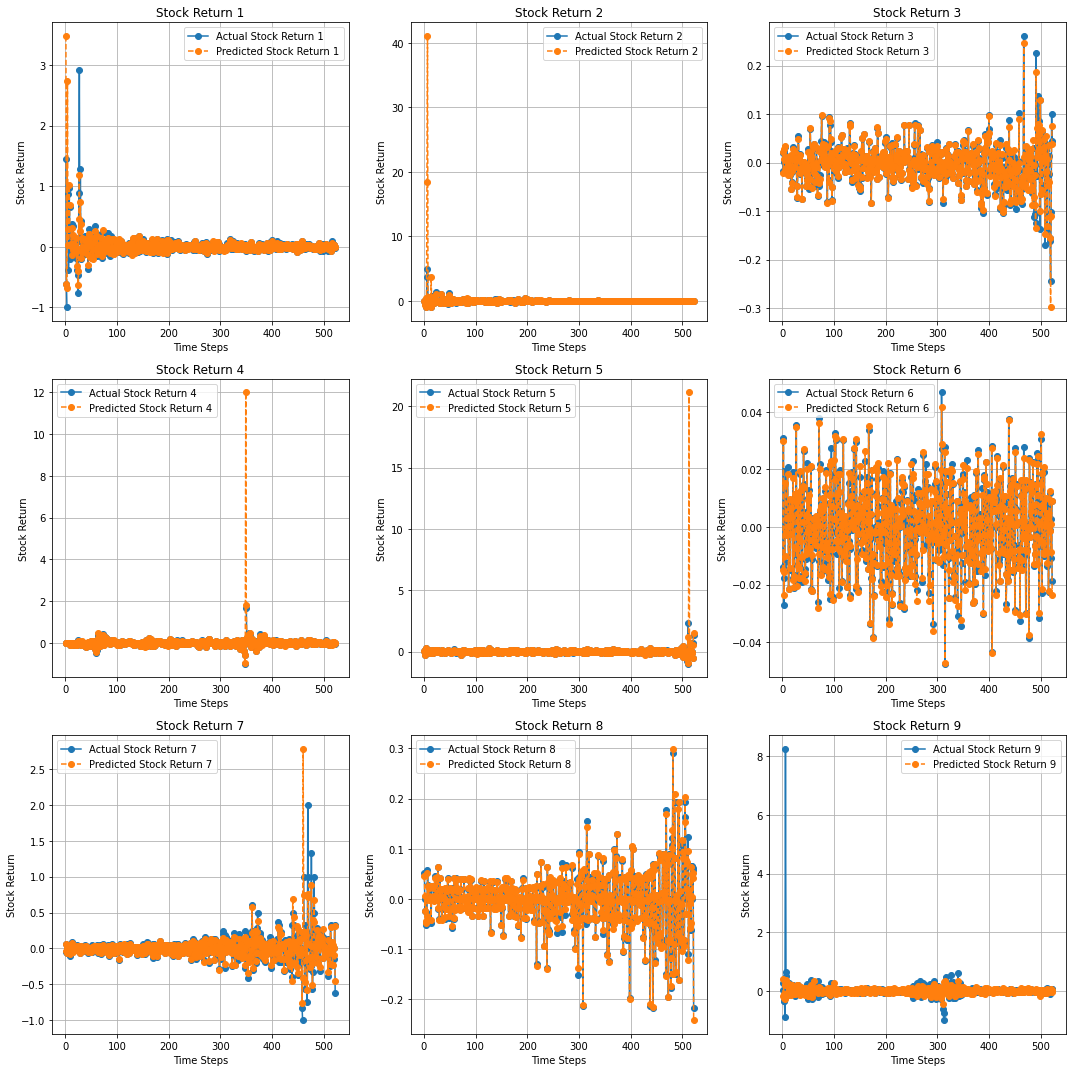

<ipython-input-35-cf24e5af1798>:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)
<ipython-input-41-479a7710ac37>:89: RuntimeWarning: divide by zero encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:89: RuntimeWarning: invalid value encountered in divide
  returns_pred = np.diff(output_features_pred, axis=0) / output_features_pred[:-1]
<ipython-input-41-479a7710ac37>:90: RuntimeWarning: divide by zero encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]
<ipython-input-41-479a7710ac37>:90: RuntimeWarning: invalid value encountered in divide
  returns_test = np.diff(output_features_test, axis=0) / output_features_test[:-1]


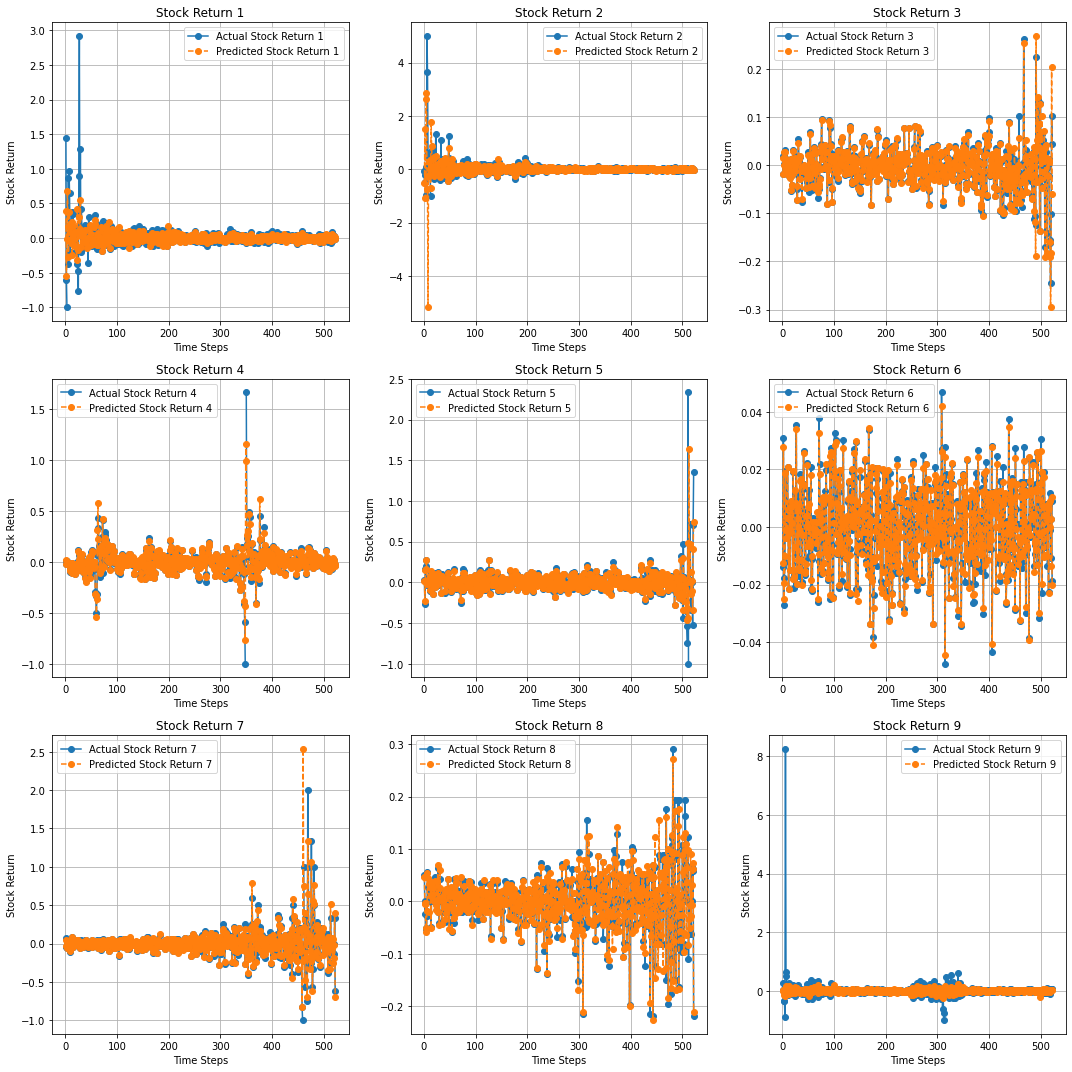

Initial Portfolio:
ABC : 1111 shares at $100.0 per share
MKV: 1984 shares at $56.0 per share
YYT: 1587 shares at $70.0 per share
PLO: 4444 shares at $25.0 per share
ERS: 1710 shares at $64.96 per share
HUY: 1459 shares at $76.12 per share
MON : 3470 shares at $32.02 per share
AQE: 4828 shares at $23.01 per share
IX50: 92 shares at $1200.0 per share
Cash: $863.64
Total Portfolio Value: $1000000.00
Day 1 - Portfolio Value: $1000000.00
Day 2 - Portfolio Value: $1000774.20
Day 3 - Portfolio Value: $995692.86
Day 4 - Portfolio Value: $998002.56
Day 5 - Portfolio Value: $1001236.14
Day 6 - Portfolio Value: $993282.70
Day 7 - Portfolio Value: $994186.50
Day 8 - Portfolio Value: $998163.22
Day 9 - Portfolio Value: $1001236.14
Day 10 - Portfolio Value: $1006630.11
Day 11 - Portfolio Value: $1007067.77
Day 12 - Portfolio Value: $1006671.29
Day 13 - Portfolio Value: $1008367.05
Day 14 - Portfolio Value: $998912.93
Day 15 - Portfolio Value: $1002912.75
Day 16 - Portfolio Value: $1005458.09
Day 17 

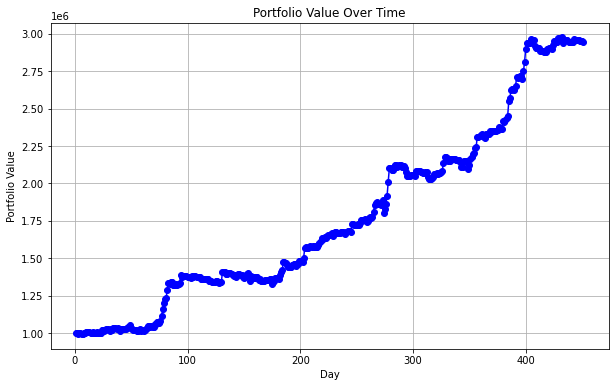

{'Average Annualized Expected Return - test': 0.5627358092649506, 'Average Annualized Expected Return - validation': 0.25067614634115554, 'Average Annualized Expected Return - train': 0.8290381822857358, 'Annualized Sharpe Ratio - test': 2.777856357976039, 'Annualized Sharpe Ratio - validation': 1.627813749421828, 'Annualized Sharpe Ratio - train': 3.7988545862699215, 'Maximum Drawdown on 6 Months - test': -0.07346580537487091, 'Maximum Drawdown on 6 Months - validation': -0.04013750113254106, 'Cumulative Return on Validation': 0.10256577, 'Cumulative Return on Test': 0.21731219999999984, 'Correlation with Equally Weighted Market Portfolio': 0.29330595953260497}


<ipython-input-50-2e527a3b194b>:69: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  correlation, _ = pearsonr(portfolio_returns[:min(len(portfolio_returns),len(market_returns))], market_returns[:min(len(portfolio_returns),len(market_returns))])


In [51]:
metrics = compute_portfolio_metrics (risk_free_rate = 0, initial_cash_=1000000) 
print(metrics)

### Some metrics that helped us to understand the dataframe.

In [184]:
# Perform one-way ANOVA for each stock return column
anova_results = {}
for stock in stocks_cleaned.columns.to_list():
    groups = [group[1] for group in cleaned_data.groupby("Macro Environment")[stock]]

    # Check if there are at least two groups with data
    if len(groups) >= 2:
        f_statistic, p_value = f_oneway(*groups)
        anova_results[stock] = (f_statistic, p_value)
    else:
        anova_results[stock] = (None, None)  # No valid ANOVA

# Print ANOVA results
for stock, (f_statistic, p_value) in anova_results.items():
    if f_statistic is not None:
        print(f"ANOVA for {stock}: F-statistic = {f_statistic}, p-value = {p_value}")
    else:
        print(f"No valid ANOVA for {stock}: Insufficient data in groups.")


ANOVA for ABC : F-statistic = 0.44492826405154895, p-value = 0.6410406553480313
ANOVA for MKV: F-statistic = 0.31569622058801483, p-value = 0.7293786007451679
ANOVA for YYT: F-statistic = 0.7222133375667242, p-value = 0.4860162696623552
ANOVA for PLO: F-statistic = 2.268265973160103, p-value = 0.10420672707100156
ANOVA for ERS: F-statistic = 1.103597250937572, p-value = 0.33221813826691016
ANOVA for HUY: F-statistic = 1.0224287644851306, p-value = 0.36022505893967266
ANOVA for MON : F-statistic = 0.5978200685293199, p-value = 0.5502732966262947
ANOVA for AQE: F-statistic = 1.3762177388058257, p-value = 0.25317398616979203
ANOVA for IX50: F-statistic = 2.526490735722864, p-value = 0.08062472821113663


Small p-value, Large F-Statistic: If you have a small p-value (e.g., p < 0.05) and a large F-statistic, it suggests that there are statistically significant differences between at least some of the groups. You would reject the null hypothesis.
Small p-value, Small F-Statistic: If you have a small p-value but a small F-statistic, it may suggest that there are statistically significant differences between groups, but the differences are not very large.
Large p-value, Large F-Statistic: If you have a large p-value (e.g., p > 0.05) and a large F-statistic, it suggests that there are no statistically significant differences between the groups. You would fail to reject the null hypothesis.
Large p-value, Small F-Statistic: If you have a large p-value and a small F-statistic, it suggests that there are no statistically significant differences between the groups, and the differences observed are not substantial.

In [185]:
# Assuming 'cleaned_data' has columns "Macro Environment" (categorical) and stock return columns

# Replace spaces with underscores in column names
cleaned_data.columns = cleaned_data.columns.str.replace(" ", "_")

# Perform one-way ANOVA
formula = f"{stock_column} ~ C(Macro_Environment)"
model = ols(formula, data=cleaned_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(cleaned_data[stock_column], cleaned_data['Macro_Environment'])
result = mc.tukeyhsd()

# Display the results
print("ANOVA results:")
print(anova_table)
print("\nTukey's HSD results:")
print(result)

ANOVA results:
                        sum_sq     df         F    PR(>F)
C(Macro_Environment)  0.000223    2.0  2.526491  0.080625
Residual              0.032811  744.0       NaN       NaN

Tukey's HSD results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
Negative  Neutral   0.0003  0.904 -0.0014 0.0021  False
Negative Positive   0.0013 0.1863 -0.0005 0.0031  False
 Neutral Positive    0.001 0.1247 -0.0002 0.0023  False
-------------------------------------------------------


If the overall ANOVA test is statistically significant (p < 0.05), post-hoc tests are performed to identify which specific pairs of groups are different from each other.
Post-Hoc Test Results:
The results of post-hoc tests provide confidence intervals and p-values for pairwise group comparisons.
Interpretation:
For each pair of groups:
If the confidence interval does not contain zero and the p-value is small (e.g., p < 0.05), it suggests a significant difference between those groups.
If the confidence interval contains zero and the p-value is not small, it suggests no significant difference.
**According to the results of the test there is a significant effect of each macroeconomic condition on the stock prices**

In [186]:
# Perform Bonferroni-corrected Tukey's HSD test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=cleaned_data[stock_column], groups=cleaned_data['Macro_Environment'], alpha=0.05)

# Display the results
print("Bonferroni-corrected Tukey's HSD results:")
print(tukey)

Bonferroni-corrected Tukey's HSD results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
Negative  Neutral   0.0003  0.904 -0.0014 0.0021  False
Negative Positive   0.0013 0.1863 -0.0005 0.0031  False
 Neutral Positive    0.001 0.1247 -0.0002 0.0023  False
-------------------------------------------------------
